In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [244]:
def draw_beta(noise_level):
    return noise_level, np.random.multivariate_normal(mean=[0, 0, 0], cov=np.eye(3)).squeeze()

In [245]:
def model(X: np.array, beta: np.array) -> np.array:
    noise_level, beta = beta
    w = np.array([[5, 3, -8],
                  [-3, 1, 2],
                  [-5, -2, 7]])
    theta = np.array([[1, 0, -0.5],
                     [0, 1, -1],
                     [-2, 1, 1]]) + np.matmul(beta, w.T)
    logits = np.matmul(X, theta)
    # Change so that larger noise level gives harder problem
    # beta = np.random.multivariate_normal(mean=[-0.5, 0.5, 0], cov=0.8*np.eye(3))
    # logits = z * beta
    # rescale so exps don't explode
    logits -= logits.max(axis=1)[:, np.newaxis]
    logits /= noise_level
    probs = np.exp(logits)
    probs /= probs.sum(axis=1)[:, np.newaxis]
    if np.isnan(probs).any():
        print(probs)
    gen = np.array([np.random.choice(3, p=p) for p in probs])
    return probs, gen

(array([458.,   0.,   0.,   0.,   0., 106.,   0.,   0.,   0., 436.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

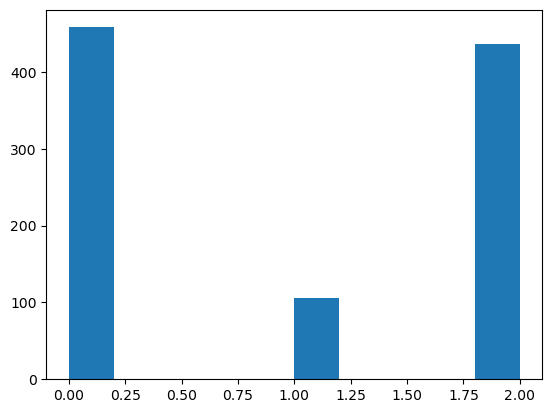

In [290]:
plt.hist(ys[:,1])

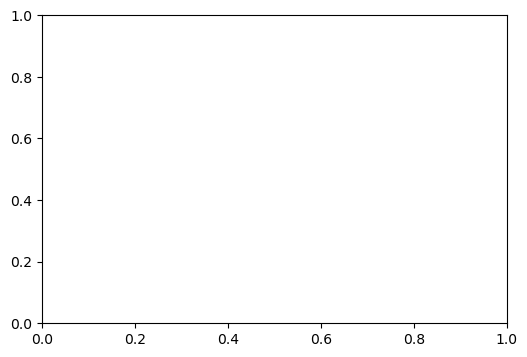

In [289]:
B = 1_000
ys = np.vstack([model(np.array([[-1, 0, 1], [1, 0, 1]]), draw_beta(0.8000))[1] for _ in range(B)])
fig, ax = plt.subplots(figsize=(6,4))
# ax.hist(p0[:, 1], bins=30)
plt.show()

In [35]:
X = np.vstack((np.arange(-50, 50), np.random.normal(size=100, scale=20), np.ones(100))).T
X[:5, ...]

array([[-50.        , -39.20649304,   1.        ],
       [-49.        ,  -1.59924115,   1.        ],
       [-48.        ,  14.11319321,   1.        ],
       [-47.        , -15.08631168,   1.        ],
       [-46.        ,  18.79796799,   1.        ]])

In [179]:
def agree(chains):
    preds = []
    for chain in chains:
        probs = []
        for beta in chain:
            prob, _ = model(X, beta)
            probs.append(prob)
        probs = np.array(probs)
        avg_probs = np.mean(probs, axis=0)
        preds.append(avg_probs.argmax(axis=1))
    preds = np.vstack(preds)
    return np.mean((preds[0] == preds[1]) & (preds[1] == preds[2]))

In [300]:
B = 1_000

In [301]:
noise_levels = [0.2, 0.8, 1.9, 10, 100, 1000, 10_000]

In [302]:
import tqdm

In [303]:
ag = []
bag = []
for noise_level in tqdm.tqdm(noise_levels):
    chain1 = np.array([draw_beta(noise_level) for _ in range(B)], dtype=object)
    chain2 = np.array([draw_beta(noise_level) for _ in range(B)], dtype=object)
    chain3 = np.array([draw_beta(noise_level) for _ in range(B)], dtype=object)
    ag.append(agree((chain1, chain2, chain3)))
    chainb1 = chain1[np.random.choice(B, size=B, replace=True)]
    chainb2 = chain1[np.random.choice(B, size=B, replace=True)]
    chainb3 = chain1[np.random.choice(B, size=B, replace=True)]
    bag.append(agree((chainb1, chainb2, chainb3)))

100%|██████████| 7/7 [02:32<00:00, 21.77s/it]


In [304]:
df = pd.DataFrame({'ag': ag, 'bag': bag}, index=noise_levels)
df

,ag,bag
0.2,0.07,1.00
0.8,0.99,0.74
1.9,1.00,0.97
10.0,0.96,0.54
100.0,0.76,1.00
1000.0,0.96,0.99
10000.0,0.92,0.57


<Axes: >

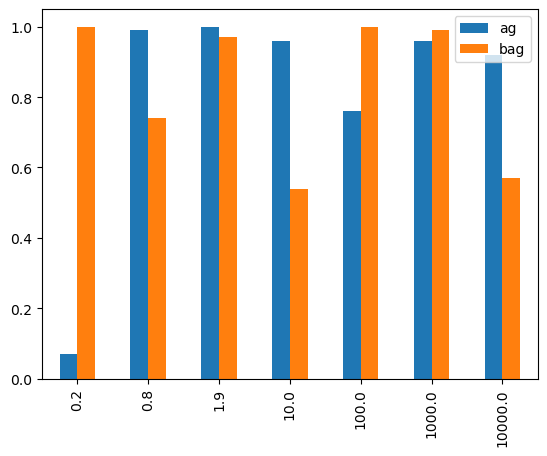

In [305]:
df.plot(kind='bar')